### Import Libraries

In [235]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import OrderedDict
import numpy as np

In [236]:
# Set seed for reproducibility
torch.manual_seed(1000)

### Load Images
Images come in different sizes and formats, therefore is pivotal transforming them to a standard size.

In [237]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
transform2 = transforms.Compose([
    transforms.RandomResizedCrop(size=100),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),

])
generator = torch.Generator().manual_seed(1000)

In [238]:
def perform_transform(dir, rotation_degrees):
    return datasets.ImageFolder(dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=rotation_degrees),
        transforms.ToTensor(),
    ]))


def increase_data(dir, n):

    data = perform_transform(dir, 0)

    for i in range(1,n):
       data += (perform_transform(dir , i*7))
    return data
      

In [239]:
data_dir = "./data/data x20/"

In [240]:

raw_dataset = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())
dataset = increase_data(data_dir, 30)
# dataset = datasets.ImageFolder(data_dir, transform=transform)
train_ds, val_ds = random_split(dataset, [0.7, 0.3], generator=generator)
training_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
validation_loader = DataLoader(val_ds, batch_size=4, shuffle=True)

In [241]:

image, label = dataset[100]

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


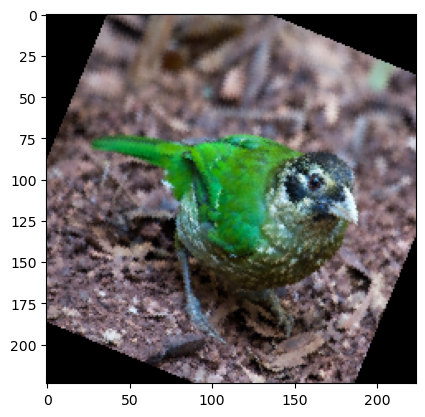

Label: 17


In [242]:
# Display image and label.
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
# Permute the dimensions of the tensor to get the color channel to the last dimension (n*n*3)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")


#### Exploring data
Most classes have around 60 instances, except for the Auklet family and the Spotted Catbird with nearly 22% less values, as shown below

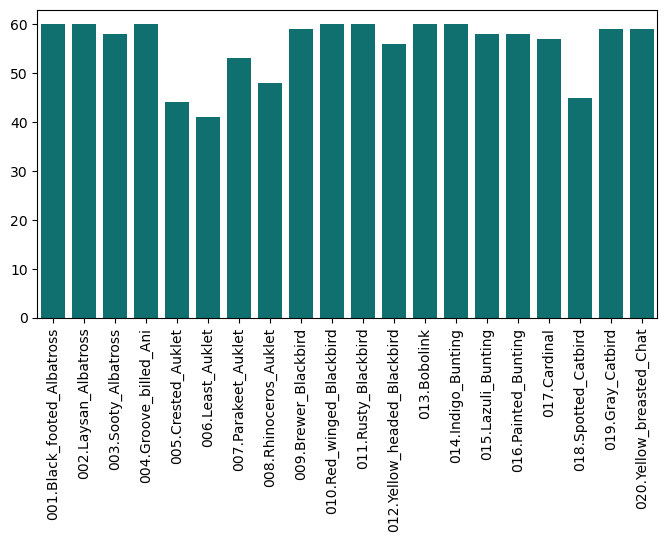

In [243]:
initial_dataset = datasets.ImageFolder(data_dir, transform=transform)
values = list(dict(Counter(initial_dataset.targets)).values())
plt.figure(figsize=(8,4))
chart = sns.barplot(x=list(range(20)), y=values, color='teal')
chart.set_xticklabels(initial_dataset.classes, rotation=90)
plt.show()

In [244]:
raw_dataset = datasets.ImageFolder(data_dir, transform=transforms.ToTensor())

shapes = {}
width = []
height = []

for x in raw_dataset:
    shapes[(x[0].size(dim=1), x[0].size(dim=2))] = shapes.get((x[0].size(dim=1), x[0].size(dim=2)), 0) + 1
    width.append(x[0].size(dim=1))
    height.append(x[0].size(dim=2))


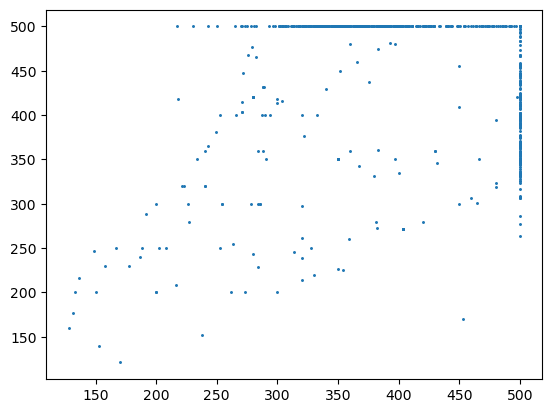

In [245]:
s = 5
plt.scatter(width, height, marker='.', s=s)
    

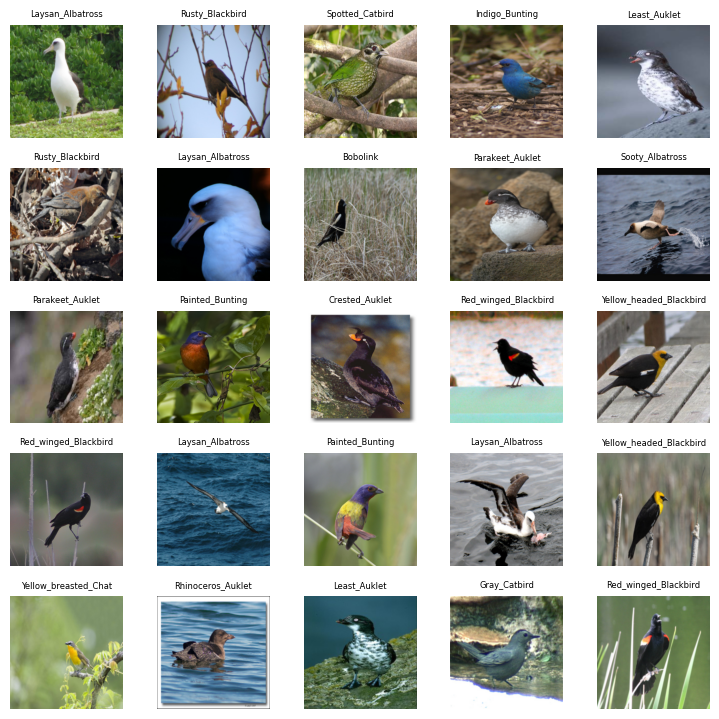

In [246]:
import random


img = plt.figure(figsize=(10,10))

for i in range(25):
    j = random.randint(0, len(initial_dataset))
    img.add_subplot(5, 5, i+1)
    plt.imshow(initial_dataset[j][0].permute(1, 2, 0))
    plt.title(initial_dataset.classes[initial_dataset[j][1]].split(".")[1], fontsize=6)
    plt.subplots_adjust(left=0.2, wspace=0.3, top=0.8)
    plt.axis("off")

### Training a model

In [247]:
# Select device, in this case Macbook Air M1 it will be using MPS
device = torch.device("mps")

##### Definintion of the CNN

In [248]:
class CUB20Classifier(nn.Module):
    def __init__(self):
        super(CUB20Classifier, self).__init__()

        self.convStack = nn.Sequential(
            nn.Conv2d(3, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Flatten())

        self.fcStack = nn.Sequential(
            nn.Linear(64 * 25 * 25, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(84, 20),
        )

    def forward(self, x):
        x = self.convStack(x)           
        x = self.fcStack(x)
        return x




In [249]:

model = CUB20Classifier()
model.to(device)


CUB20Classifier(
  (convStack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fcStack): Sequential(
    (0): Linear(in_features=40000, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=84, out_features=20, bias=True)
  )
)

In [250]:
loss_fn = torch.nn.CrossEntropyLoss()

In [251]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [252]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    correct = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader, 0):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        _, pred = torch.max(outputs.data, 1)

        correct += (pred == labels).sum().item()

        # Compute the loss and its gradients
        loss = loss_fn(outputs , labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        

    return (running_loss / i), (correct / len(train_ds))

In [253]:
# Initializing in a separate cell so we can easily add more epochs to the same run
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 15

train_loss = []
val_loss = []
acc_val = []
acc_train = []
num_correct = 0
num_samples = 0

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    num_correct = 0
    total = 0

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, acc = train_one_epoch(epoch_number)
    
    acc_train.append(acc)
    train_loss.append(avg_loss)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader, 0):
        vinputs, vlabels = vdata

        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        _, predictions = torch.max(voutputs.data, 1)

        num_correct += (predictions == vlabels).sum().item()
        total += vlabels.size(0)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    acc_val.append(num_correct / total)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('ACCURACY: {}'.format(num_correct / len(validation_loader.dataset)))
    epoch_number += 1

EPOCH 1:
LOSS train 2.6823937867963985 valid 2.167971250116706
ACCURACY: 0.2921773791728949
EPOCH 2:
LOSS train 2.0149836752626724 valid 1.5768386437960382
ACCURACY: 0.47992027902341805
EPOCH 3:
LOSS train 1.5153868777396413 valid 1.139832428965722
ACCURACY: 0.6037867463876433
EPOCH 4:
LOSS train 1.22001261325442 valid 0.9820830494190662
ACCURACY: 0.6567015445939213
EPOCH 5:
LOSS train 1.049136576159128 valid 0.8511202485724132
ACCURACY: 0.7037369207772796
EPOCH 6:
LOSS train 0.9052973318886484 valid 0.720701194832227
ACCURACY: 0.7496761335326357
EPOCH 7:
LOSS train 0.8049974974782321 valid 0.5160596920744511
ACCURACY: 0.8264075734927753
EPOCH 8:
LOSS train 0.7370928855868687 valid 0.6161223208094565
ACCURACY: 0.7977080219232685
EPOCH 9:
LOSS train 0.6427298554055044 valid 0.4042678643509954
ACCURACY: 0.8643746885899353
EPOCH 10:
LOSS train 0.6241157146090658 valid 0.39312037926006455
ACCURACY: 0.8695565520677628
EPOCH 11:
LOSS train 0.5425225824835093 valid 0.2733672589344318
ACCURACY

In [254]:
acc_train

[0.14473628016228912,
 0.33196668802049967,
 0.49139440529575057,
 0.5848387785607516,
 0.6433055733504164,
 0.6896006833226564,
 0.7249626307922272,
 0.7522528293828742,
 0.7847533632286996,
 0.7945761264146914,
 0.8219517403373906,
 0.837198377108691,
 0.8471919709587871,
 0.8563314114883621,
 0.8691437112961776]

In [255]:
max(acc_val)

0.9454907822620827

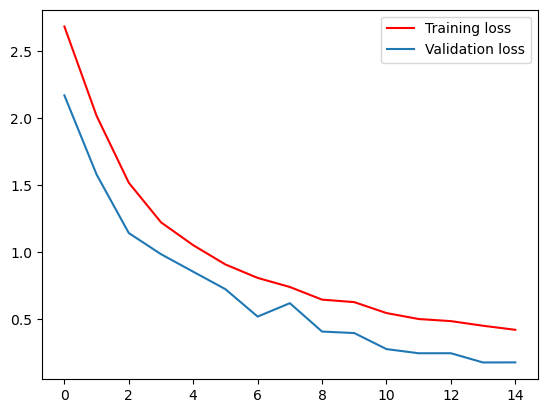

In [256]:

plt.plot(train_loss, label='Training loss', color='red')
plt.plot(val_loss, label='Validation loss')
plt.legend()

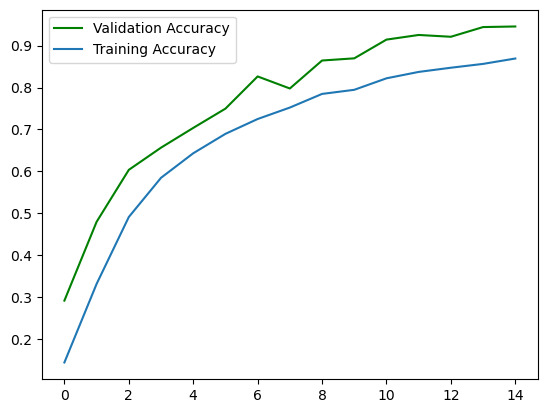

In [257]:
plt.plot(acc_val, label='Validation Accuracy', color='green')
plt.plot(acc_train, label='Training Accuracy')
plt.legend()

In [258]:
len(dataset)

33450